In [2]:
from os.path import join,expanduser
import sys
import cmocean as cmo
# identify user's home directory
user_home_dir = expanduser('~')
# import the ECCOv4 py library 
sys.path.insert(0,join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco
import botocore
import boto3
from boto3.session import Session
import cmocean
from collections import Counter
from dask.distributed import Client
import datetime
import fsspec
from gc import get_referents
import json
from matplotlib import colors as mcolors
from matplotlib.cm import ScalarMappable
import numpy as np
from pathlib import Path
from pprint import pprint
import requests
import s3fs
import sys
from sys import getsizeof
import time as time
from types import ModuleType, FunctionType
import xarray as xr
import matplotlib.pyplot as plt
import zarr



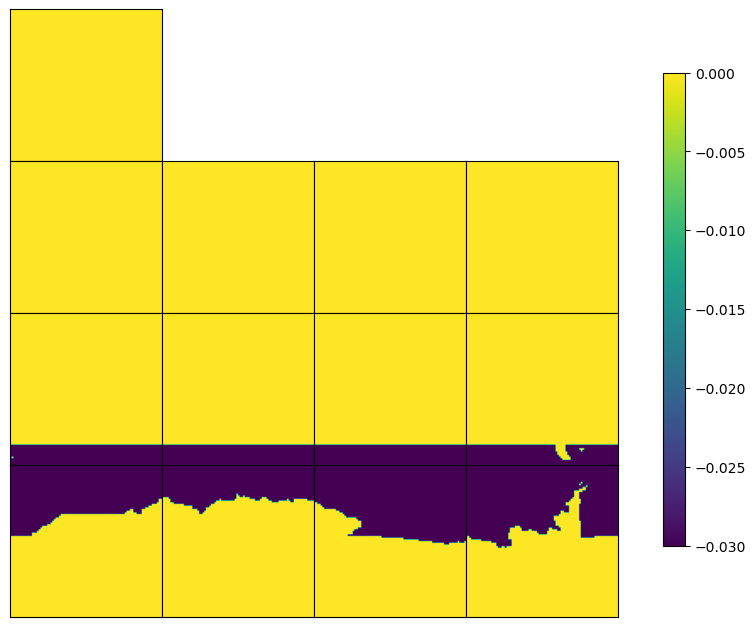

In [3]:
##1. Create the windstress mask around the SO
# Load grid #ShortNames_list = ["ECCO_L4_GEOMETRY_LLC0090GRID_V4R4"].#ecco_grid = xr.open_dataset(ShortNames_list[0])
ecco_grid    = xr.open_dataset('/efs_ecco/ECCO/V4/r4/ECCO_L4_GEOMETRY_LLC0090GRID_V4R4/GRID_GEOMETRY_ECCO_V4r4_native_llc0090.nc')
ecco_grid.load()
XC           = ecco_grid.XC.values # modle grid longitude (13x90x90)
YC           = ecco_grid.YC.values # latitudes
rA           = ecco_grid.rA.values# Also grid cell areaa in (m^2)
## Create the mask 
maskC        = ecco_grid.maskC.values # 3d mask (0 for land /1 for ocean) for model grid. It has dimensions k(50) tile(13), j(90) and i(90) and it only takes the value
maskCSurf    = maskC[0] # maskC at surface level (level = 1).take only the surface levels
lat1         = -75;lat2 = -50
#lon1 = 0;lon2 = 1170
tmp_msk      =  (YC>=lat1) & (YC<lat2)
mask_tmpplot = np.copy(tmp_msk)
mask_tmpplot[maskCSurf==False] = 0
maskfin      = xr.where(mask_tmpplot==1,-0.030,0)
## Plot the mask
#ecco.plot_tiles(mask_tmpplot, rotate_to_latlon=True, layout='latlon',show_tile_labels=False, show_colorbar=True, less_output=True)
ecco.plot_tiles(maskfin, rotate_to_latlon=True, layout='latlon', 
                show_tile_labels=False, show_colorbar=True, less_output=True)
ano_taux_c   = ecco.llc_tiles_to_compact(maskfin,
                                       less_output=True)
ano_taux_c.astype('>f4').tofile('/efs_ecco/sdarma/ECCO/EMU/SOWARM/WINDSTRESS_MASK')

load_binary_array: loading file /efs_ecco/sdarma/ECCO/EMU/SOWARM/WINDSTRESS_MASK
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4
6.705522526129215e-10


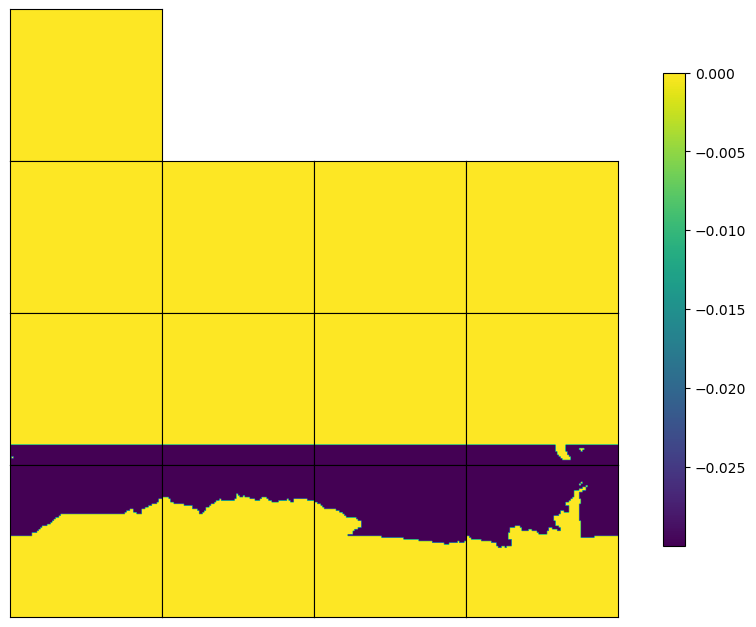

In [4]:
#2. Check the maskfin.shape
tmp_mask = ecco.read_llc_to_tiles('/efs_ecco/sdarma/ECCO/EMU/SOWARM/', 
                                  'WINDSTRESS_MASK')
ecco.plot_tiles(tmp_mask, show_colorbar=True, rotate_to_latlon=True, 
                layout ='latlon', show_tile_labels=False)
print(np.max(np.abs(maskfin-tmp_mask)))


In [5]:
#3. Calculate the windstress anomaly to see how much to make the windstress mask
directory = Path('/home/jovyan/efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_AND_ICE_SURFACE_STRESS')
# list sub-directories (one per dataset) 1992 - 2019
ecco_v4r5_mon_mean_native_dataset_paths = np.sort(list(directory.glob('*')))
TAU_X     = [[] for _ in range(12)];TAU_Y = [[] for _ in range(12)]
for i, file_path in enumerate(ecco_v4r5_mon_mean_native_dataset_paths):##This loops throughout the 336 monthly files from 1992-2019
    #print("I am in file",i)
    ds        = xr.open_dataset(file_path)
    month_idx = int(ds.time.dt.month.item()) - 1 # Extract month (1–12), convert to index (0–11)
    tau_x     = ds.oceTAUX
    tau_y     = ds.oceTAUY
    TAU_X[month_idx].append(tau_x)
    TAU_Y[month_idx].append(tau_y)

##------------------- 2. Create the windstress climatology for each windstress component --------------------------------------------
clim_TAU_X = [None]*12;clim_TAU_Y = [None]*12
for m in range(12):
    da_x          = xr.concat(TAU_X[m], dim='time')
    da_y          = xr.concat(TAU_Y[m], dim='time')
    clim_TAU_X[m] = da_x.mean(dim='time')
    clim_TAU_Y[m] = da_y.mean(dim='time')
##---------------------- 3. Create the windstress anomalies ----------------------------------------
montitles  = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
ANOM_TAU_X = [[] for _ in range(12)];ANOM_TAU_Y = [[] for _ in range(12)]
for m in range(12):# loop over months
 for y in range(0,28): # loop over the years
        anomx = TAU_X[m][y] - clim_TAU_X[m]
        ANOM_TAU_X[m].append(anomx) ##there will be ANOM_TAU_X and each of them will have 28 years inside
        anomy = TAU_Y[m][y] - clim_TAU_Y[m]
        ANOM_TAU_Y[m].append(anomy)


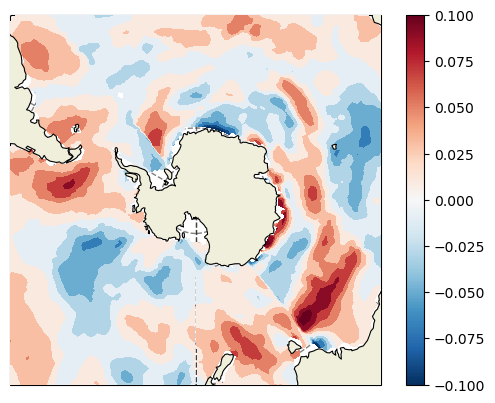

In [6]:
colorm = cmocean.cm.balance
cmin   =  -0.1;cmax = 0.1
var    = ANOM_TAU_X[1][-3][0,:,:,:] ##january/first year/have to mhednizo the xrono
ecco.plot_proj_to_latlon_grid(ds.XG, ds.YC, var, projection_type='stereo',plot_type = 'contourf', show_colorbar=True,dx=1, dy=1,lat_lim=-40,cmin=cmin,cmax=cmax,colormap=colorm,show_coastline=True,show_tile_labels = '1992 jan');




In [23]:
negw    = xr.where(var<0,var,np.nan)
meaneg1 = negw[0,:,:].mean(dim=["j","i_g"],skipna=True)
meaneg1.values

array(-0.02870658, dtype=float32)